# Validate DSPS attenuation curves from Salim

- adapted by SDC from https://github.com/ArgonneCPAC/dsps/blob/main/notebooks/validate_dsps_attenuation.ipynb
-  CCIN2P3 on K80 GPU
- conda environnment : conda_jax0325_py310
- creation date : 2023/09/29
- last update  : 2023/09/29

    pip install --upgrade  "jax[cuda11_cudnn82]"=='0.3.25' "jaxlib"=='0.3.25' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    
    python -m pip install "jax[cuda11_cudnn82]"  "jaxlib[cuda11_cudnn82]"

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import lines as mlines
import numpy as np
%matplotlib inline

In [2]:
import fsps

LSST_BANDS = fsps.filters.find_filter('lsst')
filter_wave_collector = [fsps.filters.get_filter(band).transmission[0] for band in LSST_BANDS]
filter_trans_collector = [fsps.filters.get_filter(band).transmission[1] for band in LSST_BANDS]

#def get_mags_and_spec(Av, zmet_indx=20):
def get_mags_and_spec(Av, zmet_indx=10):
    _sp = fsps.StellarPopulation(zcontinuous=0, zmet=zmet_indx, dust_type=2, dust2=Av, add_dust_emission=False)
    _wave, _fluxes = _sp.get_spectrum(peraa=True)
    _mags = _sp.get_mags(bands=LSST_BANDS)
    return _wave, _fluxes, _mags


In [3]:
avray = [0, 0.1, 0.25, 0.5, 1, 2, 4, 10]
results = [get_mags_and_spec(av) for av in avray]
spec_results = np.array([results[i][1] for i, av in enumerate(avray)])
mag_results = np.array([results[i][2] for i, av in enumerate(avray)])

wave_spec = results[0][0]

In [4]:
#from dsps.attenuation_kernels import _flux_ratio, calzetti00_k_lambda, RV_C00
#from dsps.dust.att_curves import _flux_ratio, calzetti00_k_lambda, RV_C00
from dsps.dust.att_curves import  sbl18_k_lambda, RV_C00,_frac_transmission_from_k_lambda

2023-09-29 11:08:54.232504: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
sbl18_k_lambda?

Signature:     
sbl18_k_lambda(
    wave_micron,
    uv_bump_ampl,
    plaw_slope,
    uv_bump=0.2175,
    uv_bump_width=0.035,
)
Call signature: sbl18_k_lambda(*args, **kwargs)
Type:           CompiledFunction
String form:    <CompiledFunction of <function sbl18_k_lambda at 0x7feb9447fac0>>
File:           /pbs/throng/lsst/users/dagoret/desc/JAX2023/miniconda3/envs/conda_jax0325_py310/lib/python3.10/site-packages/dsps/dust/att_curves.py
Docstring:     
Reddening curve k(λ) = A(λ) * (4.05/av) from Salim+2018

Parameters
----------
wave_micron : ndarray of shape (n, )
    Wavelength in micron

uv_bump_ampl : float
    Amplitude of the UV bump feature at 0.2175 micron

plaw_slope : float
    Slope of the power-law modification to k(λ)

uv_bump : float, optional
    Centroid of the UV bump feature in micron. Default is UV_BUMP_W0=0.2175

uv_bump_width : float, optional
    Width of the UV bump feature in micron. Default is UV_BUMP_DW=0.0350

Returns
-------
k_lambda : ndarray of shape (n,

In [6]:
_frac_transmission_from_k_lambda?

Signature:      _frac_transmission_from_k_lambda(k_lambda, av, ftrans_floor=0.0)
Call signature: _frac_transmission_from_k_lambda(*args, **kwargs)
Type:           CompiledFunction
String form:    <CompiledFunction of <function _frac_transmission_from_k_lambda at 0x7feb9447e320>>
File:           /pbs/throng/lsst/users/dagoret/desc/JAX2023/miniconda3/envs/conda_jax0325_py310/lib/python3.10/site-packages/dsps/dust/att_curves.py
Docstring:     
Fraction of flux transmitted through dust for an input reddening curve.

See Lower+22 for details.

Parameters
----------
k_lambda : ndarray of shape (n, )
    Reddening curve k(λ) computed by a model defined elsewhere

    The reddening curve k(λ) is related to the attenuation curve A(λ) as follows:

    k(λ) = A(λ) * (4.05/av)

av : float
    V-band normalization of the attenuation curve.
    av=0 corresponds to zero dust attenuation

ftrans_floor : float, optional
    Minimum value of the transmission fraction.
    Default is 0.0, in which case d

In [7]:
uv_bump_ampl = 1
plaw_slope = -0.5

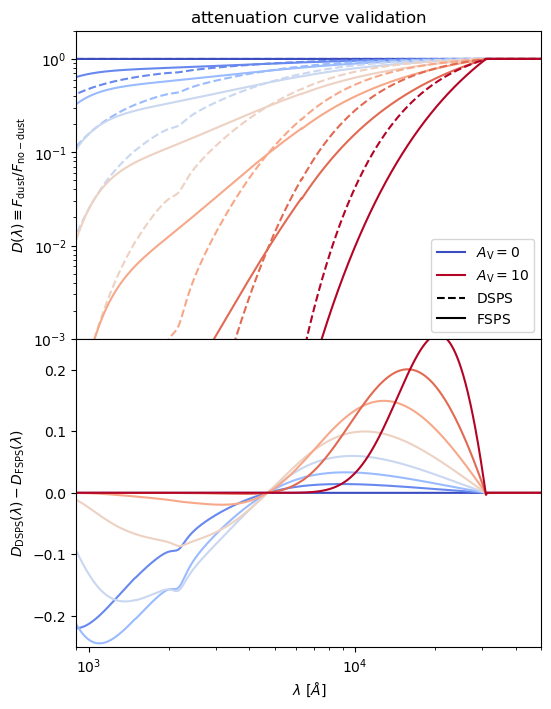

In [8]:
colors=cm.coolwarm(np.linspace(0, 1, len(avray))) # red first

mred = colors[-1]
mblue = colors[-0]

label_pat = "Av = {0:.2f}"

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
# fig.tight_layout(pad=3.0)
fig.subplots_adjust(hspace=0)
xlim = ax0.set_xlim(900, 5e4)
#xlim = ax0.set_xlim(100, 5e4)
ylim = ax0.set_ylim(1e-3, 2)
ylim = ax1.set_ylim(-.25, 0.25)
__=ax0.loglog()
dsps_attenuation_collector = []

for iav, av in enumerate(avray):
    iage = 80
    fsps_flux_ratio = spec_results[iav, iage, :] / spec_results[0, iage, :]
    __=ax0.plot(wave_spec, fsps_flux_ratio, color=colors[iav])
    
    
    wave_spec_micron = wave_spec/10_000
    
    #k = calzetti00_k_lambda(wave_spec_micron, RV_C00)
    #k = calzetti00_k_lambda(wave_spec_micron)
    k = sbl18_k_lambda(wave_spec_micron,uv_bump_ampl,plaw_slope)
    
    #dsps_flux_ratio = _flux_ratio(k, RV_C00, av)
    dsps_flux_ratio = _frac_transmission_from_k_lambda(k,av)
    __=ax0.plot(wave_spec, dsps_flux_ratio, '--', color=colors[iav])
    dsps_attenuation_collector.append(dsps_flux_ratio)

    __=ax1.plot(wave_spec, (dsps_flux_ratio - fsps_flux_ratio), color=colors[iav])
    
title = ax0.set_title(r'${\rm attenuation\ curve\ validation}$')
title = ax0.set_ylabel(r'$D(\lambda)\equiv F_{\rm dust}/F_{\rm no-dust}$')
xlabel = ax1.set_xlabel(r'$\lambda\ [\AA]$')
xlabel = ax1.set_ylabel(r'$D_{\rm DSPS}(\lambda)-D_{\rm FSPS}(\lambda)$')


red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$A_{\rm V}=10$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$A_{\rm V}=0$')
solid_line=mlines.Line2D([],[],ls='-',c='k',label=r'${\rm FSPS}$')
dashed_line=mlines.Line2D([],[],ls='--',c='k',label=r'${\rm DSPS}$')
first_legend=ax0.legend(handles=[blue_line, red_line, dashed_line, solid_line])
fig.savefig('dsps_attenuation_validation.png', bbox_extra_artists=[xlabel], bbox_inches='tight', dpi=200)